In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import math
import time
import datetime

In [17]:
def parse_datetime(row, column, fmt='%Y-%m-%d %H:%M:%S'):
    if isinstance(row[column], str):
        row[column] = time.mktime(time.strptime(row[column].strip(), fmt))
    return row

def parse_int(row, column):
    row[column] = int(row[column])
    return row

def parse_float(row, column):
    row[column] = float(row[column])
    return row

def time_transform(row, column, translate, scale):
    row[column] -= translate
    row[column] *= scale
    return row

In [169]:
up_df = pd.read_csv('../highlevel/122879.csv')
up_df.head()

,uid,Time,FanNum,PlayNum,ChargeNum
0,122879,2019-08-29 06:00:00,5847810.0,686832097.0,1310.0
1,122879,2019-08-14 15:00:01,5730681.0,677868494.0,405.0
2,122879,2019-09-03 18:00:00,5871645.0,688943219.0,31.0
3,122879,2019-08-12 21:14:04,5721837.0,677049679.0,351.0
4,122879,2019-08-08 09:00:02,5696919.0,674895294.0,155.0


In [170]:
up_df = up_df.apply(parse_datetime, axis=1, args=('Time',))
up_df = up_df.apply(parse_int, axis=1, args=('FanNum',))
up_df = up_df.apply(parse_int, axis=1, args=('PlayNum',))
up_df = up_df.apply(parse_int, axis=1, args=('ChargeNum',))
up_df.sort_values(by='Time', inplace=True, ascending=True)

In [171]:
today = datetime.date.today()
month_ago = today - datetime.timedelta(days=30)
timestamp = time.mktime(month_ago.timetuple())

up_df = up_df.loc[up_df['Time']>timestamp]
up_df = up_df.apply(time_transform, axis=1, args=('Time', timestamp, 1/(60*60)))

up_df.head()

(242, 5)


,uid,Time,FanNum,PlayNum,ChargeNum
252,122879.0,0.000556,5733520.0,677868494.0,420.0
40,122879.0,12.950556,5735410.0,678279287.0,425.0
118,122879.0,15.000278,5736023.0,678279287.0,428.0
286,122879.0,18.000278,5736809.0,678279287.0,429.0
212,122879.0,21.000278,5737690.0,678279287.0,433.0


In [172]:
field = 'FanNum'
if field == 'PlayNum':
    diff = up_df['PlayNum'].diff()
    df = up_df.loc[diff.abs() > 1e-8]
else:
    df = up_df

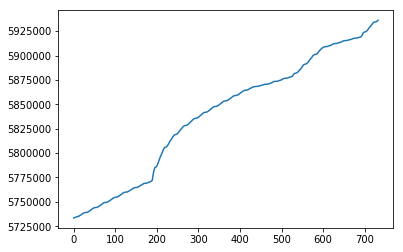

In [327]:
from sklearn.preprocessing import StandardScaler

X = df['Time'].to_numpy()[:, np.newaxis]
Y = df[field].to_numpy()

# for n in range(5):
#     Y_ = np.diff(Y, n=n)
#     Y_ = StandardScaler().fit_transform(Y_[:, np.newaxis]).reshape(-1)
#     plt.plot(X[n:], Y_)
    
# X = StandardScaler().fit_transform(X)
# Y = StandardScaler().fit_transform(Y[:, np.newaxis]).squeeze()

plt.plot(X, Y)

In [293]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(X, Y)
reg2.fit(X, Y)
reg3.fit(X, Y)
ereg.fit(X, Y)

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                   

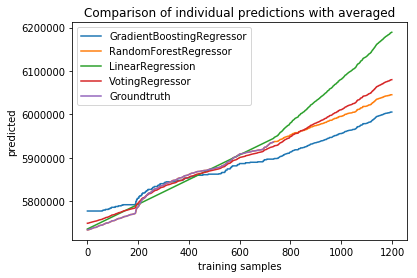

In [299]:
X_ = np.arange(1200)[:, np.newaxis]

N = np.random.normal(loc=1.0, scale=0.0001, size=X_.shape[0])
N[0:int(np.max(X)+1)] = 1.0
N = np.maximum(N, 1.0)
N = np.cumprod(N)

plt.figure()
plt.plot(X_, N*reg1.predict(X_), label='GradientBoostingRegressor')
plt.plot(X_, N*reg2.predict(X_), label='RandomForestRegressor')
plt.plot(X_, N*reg3.predict(X_), label='LinearRegression')
plt.plot(X_, N*ereg.predict(X_), label='VotingRegressor')
plt.plot(X, Y, label='Groundtruth')
plt.tick_params(axis='x', which='both')
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

In [258]:
import sklearn.isotonic
n = 2
dY = np.diff(Y, n=n)
ir = sklearn.isotonic.IsotonicRegression()
ir.fit(X[n:].squeeze(), dY)

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None, y_min=None)

[nan nan nan ... nan nan nan]


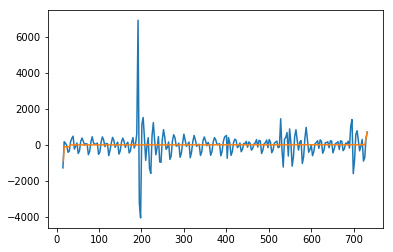

In [266]:
dX = np.arange(2000)
dY_ = ir.predict(dX)
plt.plot(X[n:], dY)
plt.plot(dX, dY_)

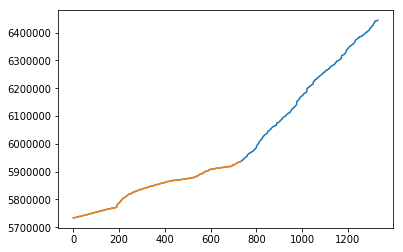

In [354]:
def random_walk(X, Y, steps, stride=1, n=1):
    X = X.squeeze()
    derivatives = [Y]
    dX = np.diff(X)
    for i in range(n):
        dY = np.diff(derivatives[-1])
        if i == 0:
            derivatives.append(dY/dX)
        else:
            derivatives.append(dY)
    Y_ = np.random.choice(derivatives.pop(), size=steps*stride)
    Y_ *= np.random.normal(loc=1.0, scale=0.5, size=steps*stride)
    for i in range(n):
        last_Y = derivatives.pop()
        Y_ *= stride
        Y_[0] += last_Y[-1]
        Y_ = np.cumsum(Y_)
    X_ = np.arange(steps*stride) + X[-1]
    X = np.hstack((X, X_))
    Y = np.hstack((Y, Y_))
    return X, Y
    
X_, Y_ = random_walk(X, Y, 200, n=1, stride=3)
dY = np.diff(Y)
dY_ = np.diff(Y_)

plt.plot(X_, Y_, label='Prediction')
# plt.plot(X_[1:], dY_, label='Prediction Derivatives')
plt.plot(X, Y, label='GroundTruth')
# plt.plot(X[1:], dY, label='GroundTruth Derivatives')